In [62]:
'''
https://github.com/CamDavidsonPilon/tdigest
https://medium.com/@mani./t-digest-an-interesting-datastructure-to-estimate-quantiles-accurately-b99a50eaf4f7
'''

import numpy as np
import seaborn as sns
from numpy.random import random
from tdigest import TDigest
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
from scipy import stats
import pandas as pd
%matplotlib inline

# TDigest Custom

In [44]:
class TDigestCustom():
    
    def __init__(self, k, method):
        self.K = k
        self.klasts = []
        
        self.kminus_one_cdf = None
        self.kth_cdf = None
        
        self.kminus_one_counts = None
        self.kth_counts = None
        
        self.method = method
        self.statistics = None
        self.p_value = None
        
    def add(self, x):
        self.klasts.append(x)
        if len(self.klasts) > self.K:
            self.klasts.pop(0)
            
        self._comp_kminus_one_cdf()
        self._comp_k_cdf()
        
    def get_stats(self):
        self._comp_statistics()
        return self.statistics, self.p_value
            
    def _comp_kminus_one_cdf(self):
        if len(self.klasts) >= self.K:
            kminus_one = self.klasts[:-1]
            kminus_one_heap = np.array(kminus_one).flatten()
            
            ecdf = ECDF(kminus_one_heap)
            self.kminus_one_cdf = ecdf(np.linspace(np.min(kminus_one_heap), np.max(kminus_one_heap), 100))
            
            counts, edges = np.histogram(kminus_one_heap, bins=20, range=(-2.0, 2.0), density=False)
            self.kminus_one_counts = counts
        
    def _comp_k_cdf(self):
        if len(self.klasts) >= self.K:
            kth = self.klasts[-1]
            
            ecdf = ECDF(kth)
            self.kth_cdf = ecdf(np.linspace(np.min(kth), np.max(kth), 100))
            
            counts, edges = np.histogram(kth, bins=20, range=(-2.0, 2.0), density=False)
            self.kth_counts = counts
            
    def _comp_statistics(self):
        if self.method == 'ks':
            self.statistics, self.p_value = stats.ks_2samp(self.kminus_one_cdf, self.kth_cdf)
        elif self.method == 'gtest':
            self.statistics, self.p_value = power_divergence(self.kth_cdf, self.kminus_one_cdf, lambda_='log-likelihood')
        else:
            raise Exception('Unknown method. Please provide KS or GTEST.')

# Simulation

In [51]:
class Simulation(object):
    def __init__(self, tdigest,
                 step_size=200,
                 size=15000,
                 anomaly_threshold=0.9,
                 distribution=np.random.normal,
                 linspace_size=100):
        super().__init__()
        self.__tdigest = tdigest
        self.__window = tdigest.K
        self.size = size
        self.s_size = step_size
        self.a_thres = anomaly_threshold
        self.__values = np.empty((0, step_size), float)
        self.__labels = np.array([])
        self.__linspace_size = linspace_size
        self.__cdfs = []
        self.statistics = np.array([])
        self.p_values = np.array([])
        self.__tdigest_custom = False
        self.__tdigest_custom_change_attempt = 0
        
    def __change_tdigest_status(self, custom):
        if self.__tdigest_custom_change_attempt == 0:
            self.__tdigest_custom_change_attempt += 1
            self.__tdigest_custom = custom
        else:
            if custom != self.__tdigest_custom:
                raise Exception("error in changing tdigest_status")      
    
    def __update(self, step_values):
        try:
            self.__tdigest.batch_update(step_values)
            self.__change_tdigest_status(False)
        except:
#             print('heheeheheh')
            self.__tdigest.add(step_values)
            self.__change_tdigest_status(True)
    
    def __compute(self, step_values, i):
        try:
            if i > self.__window:
                stat, p_value = self.__tdigest.get_stats()
                self.statistics = np.append(self.statistics, stat)
                self.p_values = np.append(self.p_values, p_value)
            self.__change_tdigest_status(True)
        except:
            if i > self.__window:
                prev_cdf = []
                curr_cdf = []
                ls = np.linspace(min(step_values),
                                 max(step_values),
                                 self.__linspace_size)
                for x in ls:
                    prev_cdf.append(self.__tdigest.cdf(x))
                prev_cdf = np.array(prev_cdf)

                ecdf = ECDF(step_values)
                curr_cdf = ecdf(ls)
                self.__cdfs.append((prev_cdf, curr_cdf))
            self.__change_tdigest_status(False)
        self.__update(step_values)
        
    def plot_pvalues(self):
        x = range(self.__window, len(self.statistics) + self.__window)
        y = self.statistics
        for x, y, l in zip(x, y, self.__labels[self.__window:]):
            if l == 0:
                plt.scatter(x, y, c='blue')
            else:
                plt.scatter(x, y, c='red')
#         for 
        plt.show()

    def get_values(self):
        return self.__values

    def get_labels(self):
        return self.__labels
    
    def get_cdfs(self):
        return self.__cdfs
        
    def run(self):
        step = 0
        i = 0
        while step <= self.size:
            i += 1
            is_anomaly = np.random.random() > self.a_thres
            step_values = np.random.normal((lambda x: 1 if not x else 20)(is_anomaly), 1, self.s_size)
            print(step_values)
            self.__labels = np.concatenate([self.__labels, [int(is_anomaly)]])
            self.__values = np.concatenate([self.__values,
                                            step_values.reshape((1, -1))])
            self.__compute(step_values, i)
            step += self.s_size

# TDigest custom test

[ 0.48313348  0.74431505  2.41243699  0.42307629  1.95098008  1.07273602
  0.72139261  0.96377064 -0.00317568 -1.39510011]
[ 1.6046576   2.25081375  1.02835896  1.8405589   1.80658179 -0.54440838
  2.57066217  0.36252537 -0.0053047   2.54778254]
[-0.80810755  0.33017807  0.82475266 -0.11764244  0.7949371   0.40652848
  1.58234034  0.62730156  0.07458635  1.23126441]
[ 1.1192732   1.75958172  0.08000315  1.23917534  2.66200854  0.64021302
 -0.03061852  1.44705227  1.10211945  1.11997561]
[-0.28317193  2.11728268  1.36310728  0.33683708 -0.56515667  2.0251167
  2.30050269  1.82634969  0.78043165  1.47651869]
[ 0.92264378 -0.82765347 -0.61387931 -0.08015257  1.14603355  2.24350439
  0.66528762  0.2426773   1.14627369  0.87258531]
[ 0.86158215  0.45389121  0.91172587  1.29337121  2.41197718  1.07544519
  0.48026468  1.79520038  2.36701164 -0.59324452]
[ 1.18949415 -0.50865827  0.03679741  2.15213314  0.93882989 -0.20565852
  1.65628576  0.53913935  1.217195    1.13984619]
[ 1.83602324 -0.2

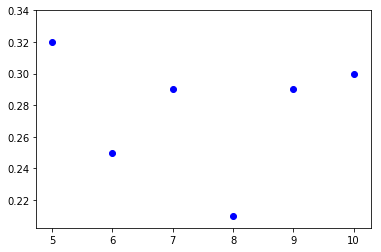

[0.32 0.25 0.29 0.21 0.29 0.3 ]


In [56]:
def tdigest_test_custom():
    tdigest = TDigestCustom(k=5, method='ks')
    sim = Simulation(tdigest,
                     step_size=10,
                     size=100,
                     anomaly_threshold=1)
    sim.run()
    labels = sim.get_labels()
    print(labels)
    print(labels[5:])
    print(sim.p_values.shape)
    sim.plot_pvalues()
    print(sim.statistics)
tdigest_test_custom()

# TDigest test

In [118]:
tdigest = TDigest(K=5)
sim = Simulation(tdigest,
                 step_size=10,
                 size=100,
                 anomaly_threshold=0.9)
sim.run()
print(sim.get_values())
sim.get_cdfs()

[[-1.43470004  3.33989969 -0.98848126 -2.75031435  3.21762184  8.56081958
   6.1248653   6.36488009 11.83759353 -2.00558591]
 [ 3.66846479 -3.38000806  5.00093466 -1.12184827  0.65553542 -0.42202175
  -5.84037127  2.95378193 -3.37712635  1.21015178]
 [-0.13044423 -4.98696987 11.48746224 -4.37550642 -0.5038416  11.32762084
   0.64067422  5.17832784 -2.17870197 -1.68466886]
 [ 2.81001809 11.16550809 -0.08743436 12.39854454 -1.0045986   2.96791104
  -3.62559559  3.6329843  -4.98012173 -3.79256267]
 [ 0.70012489  0.55375355 -7.22348787 -0.36349793  0.79992216  4.05900368
  -3.71768703 -2.96217921  1.43455644  6.73343633]
 [-0.08135478  0.64166196  8.17544335  1.06161444  0.4021015   7.13454396
  -1.2177164  -7.88146784  1.889273    4.84528325]
 [ 2.21716002 -6.60423909 10.33414885 10.11458672 -1.41097281  5.47183409
   3.14061341 -3.54126591  7.68228569  1.22103565]
 [-3.89456731 -1.22503693 -0.95953862  1.05384395  1.49580423  4.96475494
  -3.71230925  0.48340075 -3.46271812 -0.60099356]


[(array([4.85545950e-04, 2.83084384e-03, 5.17614172e-03, 7.52143961e-03,
         9.86673750e-03, 1.22120354e-02, 1.45573333e-02, 1.69026312e-02,
         1.92479290e-02, 2.00000000e-02, 2.01761035e-02, 2.39771524e-02,
         2.77782013e-02, 3.15792503e-02, 3.53802992e-02, 3.91813481e-02,
         4.00000000e-02, 4.00000000e-02, 7.05984728e-02, 7.59635709e-02,
         8.10063028e-02, 8.65708542e-02, 9.21354057e-02, 9.76999571e-02,
         1.00000000e-01, 1.00883655e-01, 1.46831625e-01, 1.60000000e-01,
         1.91783703e-01, 1.99601134e-01, 2.04944139e-01, 2.26388049e-01,
         2.32062909e-01, 2.37737769e-01, 2.40000000e-01, 2.46986981e-01,
         2.67693789e-01, 2.77801760e-01, 2.87316454e-01, 3.02244382e-01,
         3.12612936e-01, 3.20000000e-01, 3.38938765e-01, 3.73352073e-01,
         3.80000000e-01, 3.80000000e-01, 4.10458251e-01, 4.39011496e-01,
         4.69723500e-01, 4.74782579e-01, 4.79841659e-01, 4.80000000e-01,
         4.89703583e-01, 5.52912192e-01, 5.73750348

# PDF/CDF transform

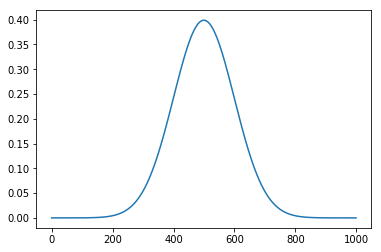

In [115]:
from numpy import diff

rvs = stats.norm
x = np.linspace(-5, 5, 1000)

rv = stats.norm
pdf = rv.pdf(x)
plt.plot(pdf)
plt.show()

# cdf = stats.norm.cdf(x, loc=0, scale=1)
# plt.plot(x, cdf)
# plt.show()

# pdf_1 = diff(cdf)/diff(x)
# sns.distplot(pdf_1)
# plt.show()

# pdf = np.random.normal(0, 2, 100)
# print(pdf)
# sns.distplot(pdf)
# plt.show()

# ecdf = ECDF(pdf)
# ls = np.linspace(-5, 5, 100 + 1)
# cdf = ecdf(ls)
# plt.plot(ls, cdf)
# plt.show()

# dx = ls[1]-ls[0]
# pdf_1 = diff(cdf)
# print(pdf_1)
# sns.distplot(pdf_1)
# plt.show()
# # pdf_1 =/ 


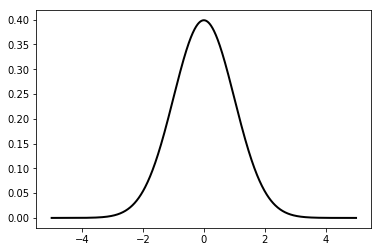

In [112]:
rv = stats.norm()
plt.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')